# Enunciado


## Descripción


En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


## Dataset


El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
- buildings
- forest
- glacier
- mountain
- sea
- street

Las imágenes están divididas en tres conjuntos:
- Train: Alrededor de 14,000 imágenes para entrenamiento.
- Test: Alrededor de 3,000 imágenes para evaluación del modelo.
- Prediction: Alrededor de 7,000 imágenes para predicción final.


## Objetivo


Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.


El modelo debe utilizar como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications
Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


# Resolución

## Entorno

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
import zipfile
import pathlib
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

## Datos

In [62]:
# Drive public ID for the zip file
images_zip = '1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'
!gdown --id $images_zip

# descarga de los tres conjuntos de datos
data_dir_train = pathlib.Path("/content/seg_train/seg_train")
data_dir_test = pathlib.Path("/content/seg_test/seg_test")
data_dir_pred = pathlib.Path("/content/seg_pred")

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

!rm 'TP1-3-natural-scenes.zip'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=6a542cab-2d93-4929-8a1f-5070728d9f12
To: /content/TP1-3-natural-scenes.zip
100% 363M/363M [00:04<00:00, 72.8MB/s]


/content/seg_train/seg_train/forest/6223.jpg


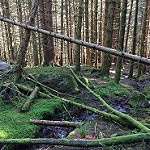

In [63]:
# sample of forest image
forest_sample = list(data_dir_train.glob('forest/*'))
print(forest_sample[14])
PIL.Image.open(str(forest_sample[14]))

In [64]:
# dataset of the three forlders
img_height, img_width = 160, 160
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_pred,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [65]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


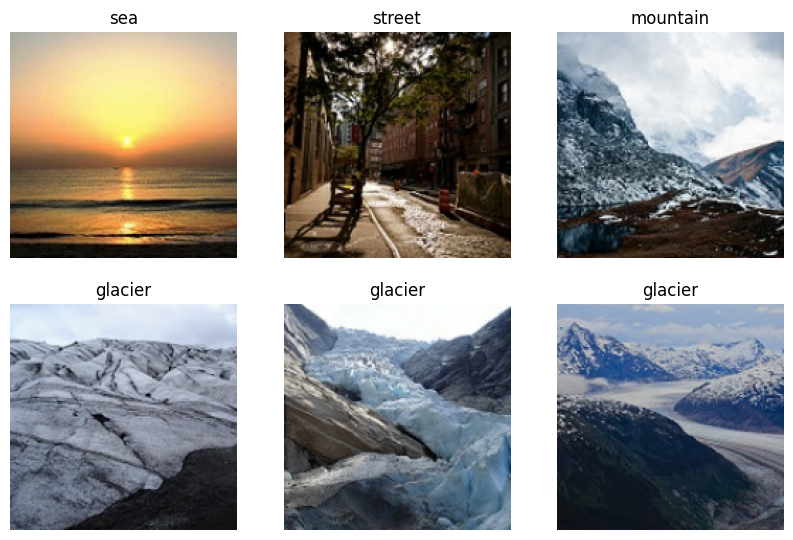

In [66]:
# samples from variuos sources
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Modelo Pre-Entrenado

In [67]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

# base arquitecture for model
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(train_ds.class_names), activation='softmax')(x)
model = Model(inputs, outputs)

# compile and train in 10 epochs the pre-trained model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
439/439 [==============================] - 18s 35ms/step - loss: 0.7680 - accuracy: 0.7061 - val_loss: 0.6586 - val_accuracy: 0.7503
Epoch 2/10
439/439 [==============================] - 14s 31ms/step - loss: 0.5799 - accuracy: 0.7809 - val_loss: 0.6229 - val_accuracy: 0.7637
Epoch 3/10
439/439 [==============================] - 14s 31ms/step - loss: 0.5317 - accuracy: 0.7978 - val_loss: 0.6033 - val_accuracy: 0.7720
Epoch 4/10
439/439 [==============================] - 14s 32ms/step - loss: 0.5024 - accuracy: 0.8113 - val_loss: 0.5857 - val_accuracy: 0.7740
Epoch 5/10
439/439 [==============================] - 14s 31ms/step - loss: 0.4825 - accuracy: 0.8201 - val_loss: 0.5642 - val_accuracy: 0.7853
Epoch 6/10
439/439 [==============================] - 14s 32ms/step - loss: 0.4655 - accuracy: 0.8259 - val_loss: 0.5685 - val_accuracy: 0.7843
Epoch 7/10
439/439 [==============================] - 14s 31ms/step - loss: 0.4495 - accuracy: 0.8322 - val_loss: 0.5505 - val_accuracy:

## Validación

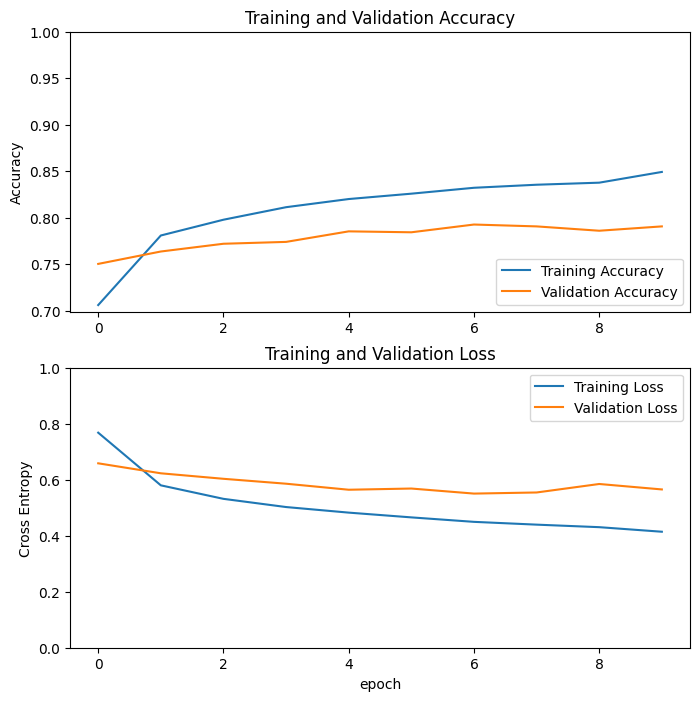

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Predicciones

1/1 [==============================] - 0s 30ms/step


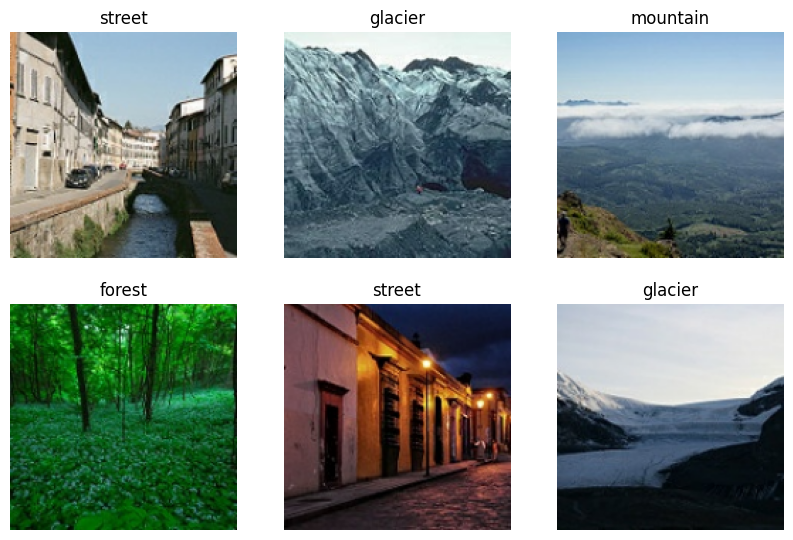

In [70]:
def predict_and_plot(model, dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(6):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            predicted_label = class_names[np.argmax(predictions[i])]
            plt.title(predicted_label)
            plt.axis("off")

# Predict and plot images with their predicted labels from the pred dataset
predict_and_plot(model, pred_ds, class_names)